In [438]:
# Author: Muhammad Fathur Rizky
# Description: This notebook is used to implement the gbdt model for time series forecasting

In [439]:
# !pip install catboost xgboost lightgbm statsmodels
# !pip install scikit-learn
# !pip uninstall -y xgboost
# !pip install xgboost

In [440]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller

from catboost import CatBoostRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

import warnings 
warnings.filterwarnings('ignore')

In [441]:
df = pd.read_csv('data\daily-minimum-temperatures-in-me.csv')
df.rename(columns={'Daily minimum temperatures': 'temperature', 'Date': 'date'}, inplace=True)
df['temperature'] = pd.to_numeric(df['temperature'], errors='coerce')
df.dropna(subset=['temperature'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3647 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         3647 non-null   object 
 1   temperature  3647 non-null   float64
dtypes: float64(1), object(1)
memory usage: 85.5+ KB


# Modelling

In [442]:
def mape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    if isinstance(y_true, pd.Series):
        y_true = y_true.values
    if isinstance(y_pred, pd.Series):
        y_pred = y_pred.values
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_squared_error(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    if isinstance(y_true, pd.Series):
        y_true = y_true.values
    if isinstance(y_pred, pd.Series):
        y_pred = y_pred.values
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    return np.mean((y_true - y_pred) ** 2)

In [443]:
split = int(len(df) * 0.8)
df_train = df[:split]
df_test = df[split:]
df_train.shape, df_test.shape

((2917, 2), (730, 2))

In [444]:
def stationarity_checking(X: np.ndarray) -> pd.DataFrame:
    result = pd.DataFrame(columns=['t-stats', 'p-value', 'stationarity'])
    adf = adfuller(X)
    result.loc['ADF'] = [adf[0], adf[1], adf[1] <= 0.05]
    kolmogorov = adfuller(X, regression='ct')
    result.loc['Kolmogorov'] = [kolmogorov[0], kolmogorov[1], kolmogorov[1] <= 0.05]
    
    return result

def lag_features(df: pd.DataFrame, column: str, lags: list) -> pd.DataFrame:
    for t in lags:
        df[f'{column}_lag_{t}'] = df[column].shift(t)
    return df

def time_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    # df['dayofyear'] = df['date'].dt.dayofyear
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df.drop(columns=['date'], inplace=True)
    return df

def time_length_control(_df: pd.DataFrame, length: int) -> pd.DataFrame:
    df = _df.copy()
    df = df.iloc[-length:]
    display(df)
    return df

In [445]:
display(stationarity_checking(df['temperature']))

,t-stats,p-value,stationarity
ADF,-4.444653,0.000247,True
Kolmogorov,-4.459142,0.001759,True


In [446]:
df_train = lag_features(df_train, 'temperature', [365, 730, 1095])
df_train = time_features(df_train)
# df_train = time_length_control(df_train, 365*5)

df_test = lag_features(df_test, 'temperature', [365, 730, 1095])
df_test = time_features(df_test)

Training catboost model


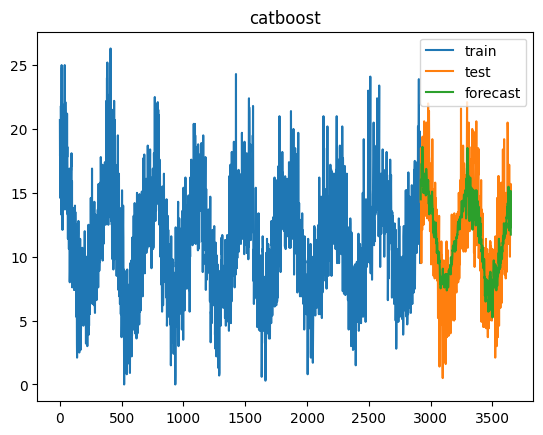

Training xgboost model


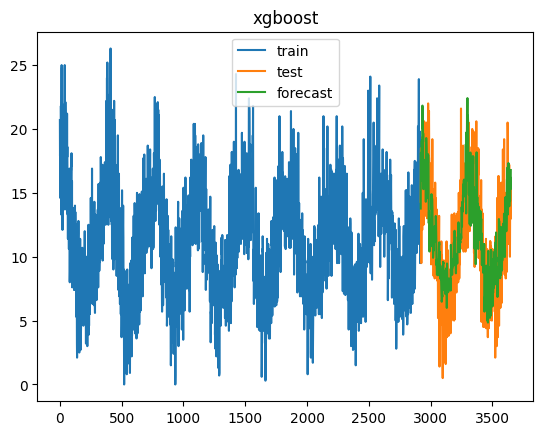

Training lightgbm model


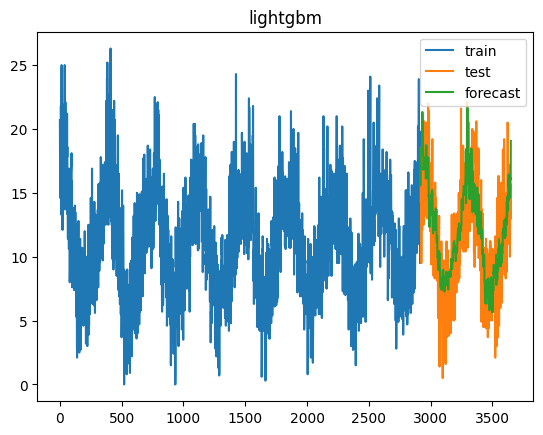

Training randomforest model


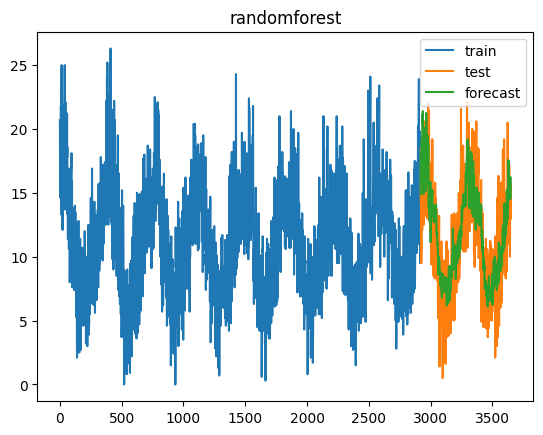

In [447]:
models = {
    'catboost': CatBoostRegressor(verbose=0, random_state=42),
    'xgboost': XGBRegressor(verbose=0, random_state=42),
    'lightgbm': LGBMRegressor(verbose=-1, random_state=42),
    'randomforest': RandomForestRegressor(random_state=42)
}

scores = pd.DataFrame(columns=['model', 'mape', 'mse'])

for name, model in models.items():
    print(f"Training {name} model")
    model.fit(df_train.drop(columns=['temperature']), df_train['temperature'])
    predictions = model.predict(df_test.drop(columns=['temperature']))
    mape_value = mape(df_test['temperature'].values, predictions)
    mse_value = mean_squared_error(df_test['temperature'].values, predictions)
    scores = pd.concat([scores, pd.DataFrame([[name, mape_value, mse_value]], columns=['model', 'mape', 'mse'])], ignore_index=True)

    df_train['temperature'].plot()
    df_test['temperature'].plot()
    pd.Series(predictions, index=df_test.index).plot()
    plt.legend(['train', 'test', 'forecast'])
    plt.title(name)
    plt.show()

In [448]:
scores

,model,mape,mse
0,catboost,28.215624,7.464388
1,xgboost,29.600069,8.762734
2,lightgbm,28.724759,7.887897
3,randomforest,27.625616,7.494204
